# Wine Price Study

#### Author: Steve Diamond [(GitHub)](https://github.com/StevenWDiamond)

### Table of Contents

#### In This Notebook:
- [Modeling](#Modeling)
    - [Model Preparation](#Model-Preparation)
    - [Models](#Models)
        - [Baseline Model](#Baseline-Model)  
        - [Linear Regression - Original Data](#Linear-Regression-(with-original-data))
        - [Linear Regression - KModes Data](#Linear-Regression-(with-KModes-data-added))
        - [Ridge Regression](#Ridge-Regression)
        - [LASSO Regression](#LASSO-Regression)
        - [Decision Tree Regression](#Decision-Tree-Regression)
        - [Random Forest Regresssion](#Random-Forest-Regresssion)
        - [Extra Trees Regression](#Extra-Trees-Regression)
        - [Feed Forward Neural Network](#Feed-Forward-Neural-Network)
- [Model Selection](#Model-Selection)
- [Model Evaluation](#Model-Evaluation)
    - [Residual Analysis](#Residual-Analysis)
    - [Coefficient Analysis/Interpretation](#Coefficient-Analysis/Interpretation)
- [Conclusions/Next Steps](#Conclusions/Next-Steps)
- [References](#References)

#### [Data Cleaning/EDA Notebook](DataCleanEDA.ipynb)
#### (includes links to the following)
- Loading Data
    - Library Imports 
    - Data Imports
    - Data Dictionary
- Data Cleaning
    - Overview Analysis
    - Cleaning/EDA Needs by Column
    - Removing Non-Red Wines
    - Removing Columns
    - Imputing Data
    - Removing Additional Wines
    - Drop Non-Prices Rows
    - Variety Combinations
    - Winery Data
- Exploratory Data Analysis
    - Feature Engineering
        - Province & Region Data
        - Special Designation Column
        - Vintage Column from Title Column
    - Data Correlations
    - Data Distributions
    - Data Interations
        - Price vs Review Score
        - Cost-Per-Point Analysis
    - Review Word Frequency Analysis
    - Post-EDA Data Preparation
- Return To EDA

#### [KPrototypes Notebook](kprototyes.ipynb)



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import sqrt
import six
import seaborn as sns

import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor,AdaBoostRegressor,ExtraTreesRegressor
from sklearn.metrics import mean_squared_error, confusion_matrix
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso, LassoCV

from tensorflow.keras.models import Sequential
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.callbacks import EarlyStopping
from keras.utils import np_utils
from keras import backend

RANDOM_STATE = 42

random_state = RANDOM_STATE

Using TensorFlow backend.


In [2]:
# allow for full printing as needed
pd.set_option("display.max_rows", None, "display.max_columns", None)

[Table of Contents](#Table-of-Contents)
## Modeling

### Model Preparation
Prior to modeling, there are several setup steps we needed to take:
- Imported two DataFrames:
    - Cleaned data from Data Cleaning/EDA notebook.
    - Cleaned data combines with KPrototypes cluster data. 

In [3]:
df = pd.read_csv('../data/clean_eda_data.csv')

In [4]:
df_w_kmodes = pd.read_csv('../data/dummied_plus_kproto.csv')

- Created a function to calculate RMSE.

In [5]:
# defining function to calculate RMSE for Train and Test scores 
def rmse(y_set, y_hat_set):
    y_set_exp     = np.exp(y_set)
    y_hat_set_exp = np.exp(y_hat_set)
    return mean_squared_error(y_set_exp,y_hat_set_exp, squared=False)

- Created several versions of X and y data for use in various models.
    1. X and y for non-KPrototypes data.
    2. X_k for the KPrototypes data (y data is the same).
    3. A non-logged version of the target data for the neural network to use.
        * Note that this is paired with the KPrototypes X data as we had already determined to use this dataframe when we imported the neural network into this notebook.
    4. Train-test split data for all of the above.

In [6]:
# X and y for non-KPrototypes data 
X = df.drop(columns='price')
y = np.log(df['price'])

# X_k and y_k for the KPrototypes data 
X_k = df_w_kmodes.drop(columns='price')

# A non-logged version of the target data for the neural network to use
y_nn = df_w_kmodes['price']

# Train-test split data for all of these
X_k_train, X_k_test, y_train, y_test = train_test_split(X_k, y, random_state = RANDOM_STATE)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = RANDOM_STATE)
X_nn_train, X_nn_test, y_nn_train, y_nn_test = train_test_split(X_k, y_nn, random_state = RANDOM_STATE)


[Table of Contents](#Table-of-Contents)
## Models

### Baseline Model
The first step in model comparison is to build a baseline model using a dummy regressor. 


In [7]:
# Instantiating and fitting the model in a pipeline
pipe_dummy = Pipeline([
    ('dummy', DummyRegressor())
])
pipe_dummy.fit(X_train,y_train)

Pipeline(steps=[('dummy', DummyRegressor())])

In [8]:
# Creating grid search parameters - in this case, just to be consistent
pipe_dummy_params = {
    'dummy__strategy': ['mean']
}

In [9]:
# Instantiating the GridSearch
pipe_dummy_gs = GridSearchCV(pipe_dummy,
                             pipe_dummy_params,
                             scoring ='neg_root_mean_squared_error',
                             cv=5)

In [10]:
# Fitting the GridSearch
pipe_dummy_gs.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=Pipeline(steps=[('dummy', DummyRegressor())]),
             param_grid={'dummy__strategy': ['mean']},
             scoring='neg_root_mean_squared_error')

In [11]:
# finding the parameters that grid search found to be the best 
pipe_dummy_gs.best_params_

{'dummy__strategy': 'mean'}

In [12]:
# finding and saving the best score from grid search (SEE NOTE BELOW)
dummy_cv = pipe_dummy_gs.best_score_
dummy_cv

-0.6640656783329778

**IMPORTANT NOTES**

There are three things that need to be said in relation to all of our grid searches and best scores:
1. We performed hyperparameter tuning on each pipeline. 
    * The settings in this notebook represent the combinations that scored the best.
1. The cross-value score is negative so that they get larger (less negative) as they get better.
    * That said, we will refer to them as getting smaller to be in sync with our RMSE scores (which are positive).
2. The RMSE cross-value scores use the logged-pricing data and, while we can compare them to each other, we cannot compare them to our other RMSE data which were scored with exponentiated data.
    * It is not possible to get a matching cross-value score from this software.

In [13]:
# Calling the function created above to determine our Train Score RMSE for this model 
dummy_train = rmse(y_train,pipe_dummy_gs.predict(X_k_train))
dummy_train

43.80603110770548

In [14]:
# Calling the function created above to determine our Test Score RMSE for this model 
dummy_test = rmse(y_test,pipe_dummy_gs.predict(X_k_test))
dummy_test

48.29262238872249

**Interpretation**

- Though it is hard to judge an RMSE at first glance, our model has what looks to be a pretty good baseline model.
    * Note that our mean price was just over \$40 so this seems to be more in the ballpark than some baseline models.


[Table of Contents](#Table-of-Contents)
### Linear Regression (with original data)

Next, we wanted to run our data through a linear regression model. We determine which of our datasets to use for the remainder of our study, the regression on both sets. We first used the data without the KPrototypes data.

In [15]:
# Instantiating and fitting the model in a pipeline
pipe_lr = Pipeline([
    ('lr', LinearRegression())
])
pipe_lr.fit(X_train,y_train)

Pipeline(steps=[('lr', LinearRegression())])

In [16]:
# Creating grid search parameters - it is now set with just the tuned parameters
pipe_lr_params = {
    'lr__fit_intercept': [True],
    'lr__normalize': [True],
    'lr__copy_X':[True]
}

In [17]:
# Instantiating the GridSearch
pipe_lr_gs = GridSearchCV(pipe_lr,
                          pipe_lr_params,
                          scoring ='neg_root_mean_squared_error',
                          cv=5)

In [18]:
# Fitting the GridSearch
pipe_lr_gs.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=Pipeline(steps=[('lr', LinearRegression())]),
             param_grid={'lr__copy_X': [True], 'lr__fit_intercept': [True],
                         'lr__normalize': [True]},
             scoring='neg_root_mean_squared_error')

In [19]:
pipe_lr_gs.best_params_

{'lr__copy_X': True, 'lr__fit_intercept': True, 'lr__normalize': True}

In [20]:
lr_cv = pipe_lr_gs.best_score_
lr_cv

-0.43244782886899336

In [21]:
lr_train = rmse(y_train,pipe_lr_gs.predict(X_train))
lr_train

37.042379190242656

In [22]:
lr_test = rmse(y_test,pipe_lr_gs.predict(X_test))
lr_test

41.431925299490615

**Interpretation**

- At this point, we at least knew that we have our baseline beat, with substantial reductions to all three scores.

[Table of Contents](#Table-of-Contents)
### Linear Regression (with KPrototypes data added)
We repeated the regression, this time using the data with the KPrototypes column.

In [23]:
# Instantiating and fitting the model in a pipeline
pipe_lr_k = Pipeline([
    ('lrk', LinearRegression())
])
pipe_lr_k.fit(X_k_train,y_train)

Pipeline(steps=[('lrk', LinearRegression())])

In [24]:
# Creating grid search parameters - it is now set with just the tuned parameters
pipe_lr_k_params = {
    'lrk__fit_intercept': [True],
    'lrk__normalize': [False],
    'lrk__copy_X':[True]
}

In [25]:
# Instantiating the GridSearch
pipe_lr_k_gs = GridSearchCV(pipe_lr_k,
                          pipe_lr_k_params,
                          scoring ='neg_root_mean_squared_error',
                          cv=5)

In [26]:
# Fitting the GridSearch
pipe_lr_k_gs.fit(X_k_train,y_train)

GridSearchCV(cv=5, estimator=Pipeline(steps=[('lrk', LinearRegression())]),
             param_grid={'lrk__copy_X': [True], 'lrk__fit_intercept': [True],
                         'lrk__normalize': [False]},
             scoring='neg_root_mean_squared_error')

In [27]:
pipe_lr_k_gs.best_params_

{'lrk__copy_X': True, 'lrk__fit_intercept': True, 'lrk__normalize': False}

In [28]:
lr_k_cv = pipe_lr_k_gs.best_score_
lr_k_cv

-0.4323850970247122

In [29]:
lr_k_train = rmse(y_train,pipe_lr_k_gs.predict(X_k_train))
lr_k_train

37.03979962450866

In [30]:
lr_k_test = rmse(y_test,pipe_lr_k_gs.predict(X_k_test))
lr_k_test

41.42269083263627

**Interpretation**

- Comparing the models both with and without the KPrototypes data, we observe that all three scores were slightly better for the data which includes the KPrototypes column.
    * **AT THIS POINT, WE CHOSE TO USE THE KPrototypes DATA IN ALL MODELING AND WE WENT BACK AND CHANGED THE BASELINE MODEL TO BE IN LINE WITH OUR OTHER MODELS**
- We further observe that the variance is fairly low. 

[Table of Contents](#Table-of-Contents)
### Ridge Regression

Although the observed variance was fairly low, we decided to see if we could regularize away some of that variance using other techniques, starting with Ridge Regression.


In [31]:
# Creating a scaled version of the X data
sc = StandardScaler()
Z_k_train = sc.fit_transform(X_k_train)
Z_k_test = sc.transform(X_k_test)


In [32]:
# Instantiating and fitting the model in a pipeline
pipe_ridge = Pipeline([
    ('ridge', Ridge(random_state=RANDOM_STATE))
])
pipe_ridge.fit(Z_k_train,y_train)

Pipeline(steps=[('ridge', Ridge(random_state=42))])

In [33]:
# Creating grid search parameters - it is now set with just the tuned parameters
pipe_ridge_params = {
    'ridge__alpha':[150],
    'ridge__max_iter': [None],
    'ridge__solver':['svd']
}

In [34]:
# Instantiating the GridSearch
pipe_ridge_gs = GridSearchCV(pipe_ridge,
                                pipe_ridge_params,
                                scoring ='neg_root_mean_squared_error',
                                cv=5)

In [35]:
# Fitting the GridSearch
pipe_ridge_gs.fit(Z_k_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ridge', Ridge(random_state=42))]),
             param_grid={'ridge__alpha': [150], 'ridge__max_iter': [None],
                         'ridge__solver': ['svd']},
             scoring='neg_root_mean_squared_error')

In [36]:
pipe_ridge_gs.best_params_

{'ridge__alpha': 150, 'ridge__max_iter': None, 'ridge__solver': 'svd'}

In [37]:
ridge_cv = pipe_ridge_gs.best_score_
ridge_cv

-0.43238470006135943

In [38]:
ridge_train = rmse(y_train,pipe_ridge_gs.predict(Z_k_train))
ridge_train

37.05002277315947

In [39]:
ridge_test = rmse(y_test,pipe_ridge_gs.predict(Z_k_test))
ridge_test

41.43367539177078

**Interpretation**

- While the cross-value score was slightly better here, both Train and Test scores were higher than the linear regression model.

[Table of Contents](#Table-of-Contents)
### LASSO Regression

Next we tried to use LASSO Regression to try an regularize.

In [40]:
# Instantiating and fitting the model in a pipeline
pipe_lasso = Pipeline([
    ('lasso', Lasso(random_state=RANDOM_STATE))
])
pipe_lasso.fit(Z_k_train,y_train)

Pipeline(steps=[('lasso', Lasso(random_state=42))])

In [41]:
# Creating grid search parameters - it is now set with just the tuned parameters
pipe_lasso_params = {
    'lasso__alpha':[.0003],
    'lasso__max_iter': [1150],
    'lasso__selection':['cyclic']
}

In [42]:
# Instantiating the GridSearch
pipe_lasso_gs = GridSearchCV(pipe_lasso,
                             pipe_lasso_params,
                             scoring ='neg_root_mean_squared_error',
                             cv=5)

In [43]:
# Fitting the GridSearch
pipe_lasso_gs.fit(Z_k_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('lasso', Lasso(random_state=42))]),
             param_grid={'lasso__alpha': [0.0003], 'lasso__max_iter': [1150],
                         'lasso__selection': ['cyclic']},
             scoring='neg_root_mean_squared_error')

In [44]:
pipe_lasso_gs.best_params_

{'lasso__alpha': 0.0003, 'lasso__max_iter': 1150, 'lasso__selection': 'cyclic'}

In [45]:
lasso_cv = pipe_lasso_gs.best_score_
lasso_cv

-0.43232568004870914

In [46]:
lasso_train = rmse(y_train,pipe_lasso_gs.predict(Z_k_train))
lasso_train

37.05506105405916

In [47]:
lasso_test = rmse(y_test,pipe_lasso_gs.predict(Z_k_test))
lasso_test

41.44558627408799

**Interpretation**

- Again, the cross-value score was slightly better here, but both Train and Test scores were higher than the linear regression model.

[Table of Contents](#Table-of-Contents)
### Decision Tree Regression
Next, we decided to try some tree models, starting with Decision Tree Regression.

In [48]:
# Instantiating and fitting the model in a pipeline
pipe_dt = Pipeline([
    ('dt', DecisionTreeRegressor(random_state= RANDOM_STATE))
])
pipe_dt.fit(X_k_train,y_train)

Pipeline(steps=[('dt', DecisionTreeRegressor(random_state=42))])

In [49]:
# Creating grid search parameters - it is now set with just the tuned parameters
pipe_dt_params = {
    'dt__ccp_alpha':[0.00009],
    'dt__max_features': [250],
    'dt__min_samples_leaf':[5],
    'dt__min_samples_split':[6]
}

In [50]:
# Instantiating the GridSearch
pipe_dt_gs = GridSearchCV(pipe_dt,
                             pipe_dt_params,
                             scoring ='neg_root_mean_squared_error',
                             cv=5)

In [51]:
# Fitting the GridSearch
pipe_dt_gs.fit(X_k_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('dt',
                                        DecisionTreeRegressor(random_state=42))]),
             param_grid={'dt__ccp_alpha': [9e-05], 'dt__max_features': [250],
                         'dt__min_samples_leaf': [5],
                         'dt__min_samples_split': [6]},
             scoring='neg_root_mean_squared_error')

In [52]:
pipe_dt_gs.best_params_

{'dt__ccp_alpha': 9e-05,
 'dt__max_features': 250,
 'dt__min_samples_leaf': 5,
 'dt__min_samples_split': 6}

In [53]:
dt_cv = pipe_dt_gs.best_score_
dt_cv

-0.4314121919799597

In [54]:
dt_train = rmse(y_train,pipe_dt_gs.predict(X_k_train))
dt_train

34.18372286652938

In [55]:
dt_test = rmse(y_test,pipe_dt_gs.predict(X_k_test))
dt_test

38.78587989467238

**Interpretation**

- In contrast to our Ridge and LASSO models, here we find that the Decision Tree model beat the regression model on all three scores.
- The variance is pretty low so we moved forward with additional tree-based models to see if we could get better scores.

[Table of Contents](#Table-of-Contents)
### Random Forest Regression

In [57]:
# Instantiating and fitting the model in a pipeline
pipe_rf = Pipeline([
    ('rf', RandomForestRegressor(random_state=RANDOM_STATE))
])
pipe_rf.fit(X_k_train,y_train)

Pipeline(steps=[('rf', RandomForestRegressor(random_state=42))])

In [58]:
# Creating grid search parameters - it is now set with just the tuned parameters
pipe_rf_params = {
    'rf__n_estimators' : [160],
    'rf__max_features' : [.14],
    'rf__min_samples_split': [3],
    'rf__min_samples_leaf': [2],
    'rf__max_depth': [80],
    'rf__bootstrap': [True],
}

In [59]:
# Instantiating the GridSearch
pipe_rf_gs = GridSearchCV(pipe_rf,
                             pipe_rf_params,
                             scoring ='neg_root_mean_squared_error',
                             cv=5)

In [60]:
# Fitting the GridSearch
pipe_rf_gs.fit(X_k_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('rf',
                                        RandomForestRegressor(random_state=42))]),
             param_grid={'rf__bootstrap': [True], 'rf__max_depth': [80],
                         'rf__max_features': [0.14],
                         'rf__min_samples_leaf': [2],
                         'rf__min_samples_split': [3],
                         'rf__n_estimators': [160]},
             scoring='neg_root_mean_squared_error')

In [61]:
pipe_rf_gs.best_params_

{'rf__bootstrap': True,
 'rf__max_depth': 80,
 'rf__max_features': 0.14,
 'rf__min_samples_leaf': 2,
 'rf__min_samples_split': 3,
 'rf__n_estimators': 160}

In [62]:
rf_cv = pipe_rf_gs.best_score_
rf_cv

-0.39185403457201895

In [63]:
rf_train = rmse(y_train,pipe_rf_gs.predict(X_k_train))
rf_train

31.542029752329626

In [64]:
rf_test = rmse(y_test,pipe_rf_gs.predict(X_k_test))
rf_test

37.96518975602316

**Interpretation**

- The Random Forest model beat the Decision Tree Model in all three scores.
- It did have higher variance but we will trade that for the better model.
- We decided to test one last tree regressor.

[Table of Contents](#Table-of-Contents)
### Extra Trees Regression

In [65]:
# Instantiating and fitting the model in a pipeline
pipe_et = Pipeline([
    ('et', ExtraTreesRegressor(random_state=RANDOM_STATE))
])
pipe_et.fit(X_k_train,y_train)

Pipeline(steps=[('et', ExtraTreesRegressor(random_state=42))])

In [66]:
# Creating grid search parameters - it is now set with just the tuned parameters
pipe_et_params = {
    'et__n_estimators' : [195],
    'et__max_features' : [.17],
    'et__min_samples_split': [3],
    'et__min_samples_leaf': [2],
    'et__max_depth': [85]
}

In [67]:
# Instantiating the GridSearch
pipe_et_gs = GridSearchCV(pipe_et,
                             pipe_et_params,
                             scoring ='neg_root_mean_squared_error',
                             cv=5)

In [68]:
# Fitting the GridSearch
pipe_et_gs.fit(X_k_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('et',
                                        ExtraTreesRegressor(random_state=42))]),
             param_grid={'et__max_depth': [85], 'et__max_features': [0.17],
                         'et__min_samples_leaf': [2],
                         'et__min_samples_split': [3],
                         'et__n_estimators': [195]},
             scoring='neg_root_mean_squared_error')

In [69]:
pipe_et_gs.best_params_

{'et__max_depth': 85,
 'et__max_features': 0.17,
 'et__min_samples_leaf': 2,
 'et__min_samples_split': 3,
 'et__n_estimators': 195}

In [70]:
et_cv = pipe_et_gs.best_score_
et_cv

-0.3891388854005675

In [71]:
et_train = rmse(y_train,pipe_et_gs.predict(X_k_train))
et_train

30.625261939060817

In [72]:
et_test = rmse(y_test,pipe_et_gs.predict(X_k_test))
et_test

37.58288600299928

**Interpretation**

- Our Extra Trees model continued the trend, beating the Random Forest Model on all three scores.
- Its variance looks to be a little higher.
- As one final check, we ran our data through a feed forward neural network.

[Table of Contents](#Table-of-Contents)
### Feed Forward Neural Network

In [73]:
X_k_train.shape  # used to set input_shape below

(53799, 370)

In [78]:
# Creating neural network topology
# a sequential model
model = Sequential()

# 2 dense hidden layers, each with a dropout layer for regularization
model.add(Dense(128,input_shape=(370,), activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))

# A dense output layer using sigmoid activation for linear regression
model.add(Dense(1,activation='sigmoid'))

# early stopping added for addtional regularization
es = EarlyStopping(monitor='val_loss', patience=5)

In [79]:
# built function to compute RMSE metric
def rmse(y_true, y_pred):
    return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1))

In [80]:
# Compiling network
model.compile(loss="bce", optimizer="adam", metrics=[rmse])

In [81]:
# fitting our network
history = model.fit(
    Z_k_train, y_nn_train,
    batch_size=128,
    validation_data=(Z_k_test, y_nn_test),
    epochs=5,
    verbose=1
)

Epoch 1/5
421/421 [==============================] - 1s 3ms/step - loss: -369100.6875 - rmse: 39.1546 - val_loss: -1605585.5000 - val_rmse: 39.1307
Epoch 2/5
421/421 [==============================] - 1s 3ms/step - loss: -6551961.5000 - rmse: 39.1482 - val_loss: -14306380.0000 - val_rmse: 39.1307
Epoch 3/5
421/421 [==============================] - 1s 3ms/step - loss: -29082538.0000 - rmse: 39.1482 - val_loss: -47938152.0000 - val_rmse: 39.1307
Epoch 4/5
421/421 [==============================] - 1s 3ms/step - loss: -76419304.0000 - rmse: 39.1482 - val_loss: -109659272.0000 - val_rmse: 39.1307
Epoch 5/5
421/421 [==============================] - 1s 3ms/step - loss: -155416624.0000 - rmse: 39.1482 - val_loss: -206710880.0000 - val_rmse: 39.1307


In [82]:
# Evaluate model on test data.
ffnn_train = model.evaluate(Z_k_train, y_nn_train, verbose = 1)
ffnn_test = model.evaluate(Z_k_test, y_nn_test, verbose = 1)

labels = model.metrics_names

# Show model performance.
print(f'Train {labels[0]}: {ffnn_train[0]}')
print(f'Train {labels[1]}: {ffnn_train[1]}')
print(f'Test {labels[0]}: {ffnn_test[0]}')
print(f'Test {labels[1]}: {ffnn_test[1]}')

561/561 [==============================] - 1s 918us/step - loss: -206710768.0000 - rmse: 39.1307
Train loss: -207528448.0
Train rmse: 39.14820098876953
Test loss: -206710768.0
Test rmse: 39.13071060180664


**Interpretation**

- Our neural network scored comparatively well but did not equal the train or test scores for either Random Forest or Extra Trees.
- This model clearly had the lowest variance.
- It should be noted that we did try to tune the network: 
    * No changes to our parameters (including numbers of neurons, batch_size, epochs) had any effect on the scoring.
    * The model always came to its final score by the second epoch.

[Table of Contents](#Table-of-Contents)
## Model Selection
To help us select our model, we compiled all of the results from above into lists then adding those lists as columns in a DataFrame.

In [83]:
model_list = ['Dummy Regression', 'Linear Regression', 'Ridge Regression', 'LASSO Regression', 'Decision Tree Regression', 'Random Forest Regression', 'Extra Tree Regression', 'Feed Forward Neural Network']
cv_list = [dummy_cv, lr_k_cv, ridge_cv, lasso_cv, dt_cv, rf_cv, et_cv, 'NA']
train_list = [dummy_train, lr_k_train, ridge_train, lasso_train, dt_train, rf_train, et_train, ffnn_train[1]]
test_list = [dummy_test, lr_k_test, ridge_test, lasso_test, dt_test, rf_test, et_test, ffnn_test[1]]
model_selection = pd.DataFrame()
model_selection['model']       = model_list
model_selection['cv_score']    = cv_list
model_selection['train_score'] = train_list
model_selection['test_score']  = test_list


In [84]:
# Display new dataframe
model_selection

,model,cv_score,train_score,test_score
0,Dummy Regression,-0.664066,43.806031,48.292622
1,Linear Regression,-0.432385,37.039800,41.422691
2,Ridge Regression,-0.432385,37.050023,41.433675
3,LASSO Regression,-0.432326,37.055061,41.445586
4,Decision Tree Regression,-0.431412,34.183723,38.785880
5,Random Forest Regression,-0.391854,31.542030,37.965190
6,Extra Tree Regression,-0.389139,30.625262,37.582886
7,Feed Forward Neural Network,NA,39.148201,39.130711


In [85]:
# For presentation purposes, create a dataframe without cross-value scores
model_selection.drop(columns='cv_score', inplace=True)

In [86]:
# Highlight row with the best test score
def highlight_lowest(x):
    if x['test_score'] < 39.6:
        return ['background-color: yellow']*3
    else:
        return ['background-color: white']*3
model_selection.style.apply(highlight_lowest, axis=1).hide_index()

model,train_score,test_score
Dummy Regression,43.806031,48.292622
Linear Regression,37.039800,41.422691
Ridge Regression,37.050023,41.433675
LASSO Regression,37.055061,41.445586
Decision Tree Regression,34.183723,38.785880
Random Forest Regression,31.542030,37.965190
Extra Tree Regression,30.625262,37.582886
Feed Forward Neural Network,39.148201,39.130711


Looking at all of our models, we had a difficult choice to make.
- Our neural network had incredibly low variance but we decided to trade variance for better scoring.
- Our Extra Trees model outdid all other models for cross-value score, train score and test score so this is our model of choice.
- Since Extra Trees has little to no interpretability, we will also run a Statsmodel OLS regression to look at the significance our features and the power of their coefficients.

[Table of Contents](#Table-of-Contents)
## Model Evaluation

### Residual Analysis

To evaluate the power of our model, we will look at our residuals.

In [87]:
# Getting predictions from our model
predictions = pipe_et_gs.predict(X_k_test).tolist()

In [88]:
# Exponentiating those predictions
predictions = [np.exp(number) for number in predictions]

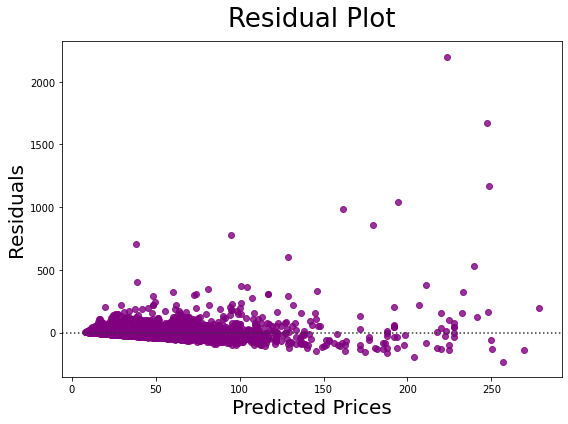

In [89]:
# Scatterplot of Predicted Price vs Residuals
# establish figure and axes objects
fig = plt.figure(figsize=(8,6))
ax = plt.gca()

# plotting prices x score
sns.residplot(x=predictions, y= y_nn_test, color='purple')

# adding line for avg. price x score
# sns.lineplot(x=x2, y=y2,color='orange')

## Notice the change to the method names ##
ax.set_title('Residual Plot', fontsize=26, pad=15)
ax.set_xlabel('Predicted Prices', fontsize=20)
ax.set_ylabel('Residuals', fontsize=20)

fig.tight_layout();

**Interpretaton**

- This plot suggests that our modle is far from ideal. 
- There is some aspect of higher-priced wines that we are missing.
    - This is why our lower predictions are far more in the ballpark of what we would hope to see.
    - The problems for our higher predictions probably reflect the link between price and review score thaat we saw earlier. The highest scoring wines went up sharply in price and our model is having trouble accounting for that effect.

### Coefficient Analysis/Interpretation

In [90]:
# Telling statsmodels to add a constant (Intercept)
X = sm.add_constant(X)

In [91]:
# Creating and fitting the OLS (linear regression) model
model = sm.OLS(y,X)
results = model.fit()

In [92]:
# Calling the results
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.582
Model:                            OLS   Adj. R-squared:                  0.580
Method:                 Least Squares   F-statistic:                     269.6
Date:                Thu, 25 Feb 2021   Prob (F-statistic):               0.00
Time:                        14:41:56   Log-Likelihood:                -41137.
No. Observations:               71732   AIC:                         8.301e+04
Df Residuals:                   71362   BIC:                         8.641e+04
Df Model:                         369                                         
Covariance Type:            nonrobust                                         
==================================================================================================================
                                                     coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------
const                                             -5.3588      0.078    -68.277      0.000      -5.513      -5.205
points                                             0.0958      0.001    161.345      0.000       0.095       0.097
high_q_term                                        0.0696      0.005     15.289      0.000       0.061       0.079
vintage                                            0.0082      0.001     16.451      0.000       0.007       0.009
country_Argentina                                  0.0924      0.054      1.717      0.086      -0.013       0.198
country_Australia                                  0.1330      0.052      2.559      0.010       0.031       0.235
country_Austria                                    0.1936      0.066      2.949      0.003       0.065       0.322
country_Brazil                                     0.3114      0.100      3.121      0.002       0.116       0.507
country_Bulgaria                                  -0.3778      0.115     -3.297      0.001      -0.602      -0.153
country_Canada                                     0.4961      0.101      4.902      0.000       0.298       0.694
country_Chile                                      0.0465      0.052      0.889      0.374      -0.056       0.149
country_Croatia                                    0.0219      0.116      0.189      0.850      -0.206       0.250
country_France                                     0.2387      0.048      5.018      0.000       0.145       0.332
country_Georgia                                   -0.4267      0.149     -2.873      0.004      -0.718      -0.136
country_Germany                                    0.1070      0.064      1.669      0.095      -0.019       0.233
country_Greece                                     0.1532      0.064      2.396      0.017       0.028       0.279
country_Hungary                                    0.4078      0.086      4.739      0.000       0.239       0.576
country_Israel                                     0.1676      0.065      2.570      0.010       0.040       0.295
country_Italy                                      0.1536      0.048      3.208      0.001       0.060       0.247
country_Mexico                                     0.4085      0.080      5.076      0.000       0.251       0.566
country_Moldova                                   -0.2714      0.095     -2.856      0.004      -0.458      -0.085
country_New Zealand                                0.0846      0.072      1.170      0.242      -0.057       0.226
country_Portugal                                  -0.2143      0.064     -3.340      0.001      -0.340      -0.089
country_Romania                                   -0.5414      0.076     -7.116      0.000   

**Interpretation**

- While R-squared is not our metric for this study, the .582 score suggests that all of our models are far from perfect.
- That said, it is still valuable to look at the significant features and understand what they mean.

In [93]:
# Code found at:
# https://stackoverflow.com/questions/51734180/converting-statsmodels-summary-object-to-pandas-dataframe/52976810
#  Creating a DataFrame from the lower portion of the OLS summary

def results_summary_to_dataframe(results):
    '''take the result of an statsmodel results table and transforms it into a dataframe'''
    pvals = results.pvalues
    coeff = results.params
    conf_lower = results.conf_int()[0]
    conf_higher = results.conf_int()[1]

    results_df = pd.DataFrame({"pvals":pvals,
                               "coeff":coeff,
                               "conf_lower":conf_lower,
                               "conf_higher":conf_higher
                                })

    #Reordering...
    results_df = results_df[["coeff","pvals","conf_lower","conf_higher"]]
    return results_df

In [94]:
# calling code to create dataframe
df_ols = results_summary_to_dataframe(results)

Our next step is to create a new column to examine our coefficients. 
- Since they are based on a logged target, we are exponentiating, subtracting one and multiplying by 100. 
- For each, the result is the percentage change in price for a unit change in the feature.
    - Note that for many of our features (including the countries, the regions and the varieties), this just means that if X is true (i.e. the wine is from France), the price increases (or decreases) by this percent.

In [95]:
df_ols['pct_change_in_y'] = (np.exp(df_ols['coeff']) - 1) *100

In [96]:
# Removing quartile ranges from dataframe and moving pct_change next to coeff
df_ols = df_ols.loc[:,['coeff','pct_change_in_y', 'pvals']]
df_ols.head()

,coeff,pct_change_in_y,pvals
const,-5.358764,-99.529328,0.000000e+00
points,0.095850,10.059383,0.000000e+00
high_q_term,0.069601,7.208037,1.101370e-52
vintage,0.008247,0.828116,1.065134e-60
country_Argentina,0.092350,9.674910,8.602540e-02


In [97]:
# Creating masks to (1) limit lists to only significant features (2) separate into groups 
# positive change vs negative change
significant = df_ols['pvals'] <=.05
positive_change = df_ols['pct_change_in_y'] > 0
negative_change = df_ols['pct_change_in_y'] < 0

# Creating a dataframe of signficant positive features and then saving as sorted highest to lowest change
df_ols_pos = df_ols.loc[significant & positive_change]
df_ols_pos = df_ols_pos.sort_values('pct_change_in_y', ascending=False)
# Creating similar dataframe for negative features and dropping the row for our constant
df_ols_neg = df_ols.loc[significant & negative_change]
df_ols_neg = df_ols_neg.sort_values('pct_change_in_y', ascending=True)
df_ols_neg.drop('const', inplace=True)

In [98]:
# confirm positive
df_ols_pos.head()

,coeff,pct_change_in_y,pvals
region_Chambolle-Musigny,0.811386,125.102503,1.230812e-37
region_Vosne-Romanée,0.775194,117.101354,3.574594e-31
region_Pomerol,0.768636,115.682280,1.081560e-47
region_Amarone della Valpolicella Classico,0.749925,111.684113,3.175426e-119
variety_Maturana,0.732457,108.018560,5.358843e-05


In [99]:
# confirm negative
df_ols_neg.head()

,coeff,pct_change_in_y,pvals
region_Vin de Pays d'Oc,-0.684332,-49.557271,2.216462e-27
region_Bordeaux,-0.613772,-45.869491,1.968498e-150
region_South Eastern Australia,-0.578784,-43.942019,1.389698e-30
region_Maipo Valley-Colchagua Valley,-0.568157,-43.343106,2.291144e-02
region_California,-0.556054,-42.653237,1.070161e-249


Below, we are plotting the largest 15 variables by percent change for each list. 

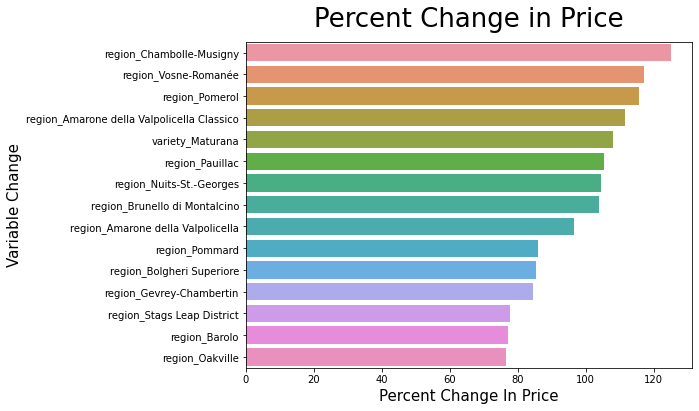

In [100]:
df_ols_pos = df_ols_pos.head(15)

plt.figure(figsize=(8,6))
plt.title('Percent Change in Price',fontsize=26, pad = 15)

# plotting prices x score
ax1 = sns.barplot(x= 'pct_change_in_y',y=df_ols_pos.index,data=df_ols_pos, orient='h')
# ax2 = sns.set(rc={"lines.linewidth": 3})
# ax2 = sns.lineplot(x= [.5,.5], y=[0,1],color='orange');
ax1.set_xlabel('Percent Change In Price', fontsize=15)
ax1.set_ylabel('Variable Change', fontsize=15);

**Interpretation**

- It is interesting to see that 14 of the top 15 positive movers are regions and most of those are european.
- The only non-region is the Maturana varietal, a near-extinct grape from the Rioja region of Spain.
- A few important side notes on the positive side that didn't make our top 15:
    * Our designation feature for reserve wines tells us to expect a 7.2% increase in price for such a wine (assuming all other factors are constant) though we learned in our EDA that the average scores do not suggest we are getting better wine.
    * The review score feature predicts a 10% increase for each point increase in the score (assuming all other factors are constant).
    * Finally, our vintage feature suggests that wine value increases by 0.8% for each year that it ages (assuming all other factors are constant)

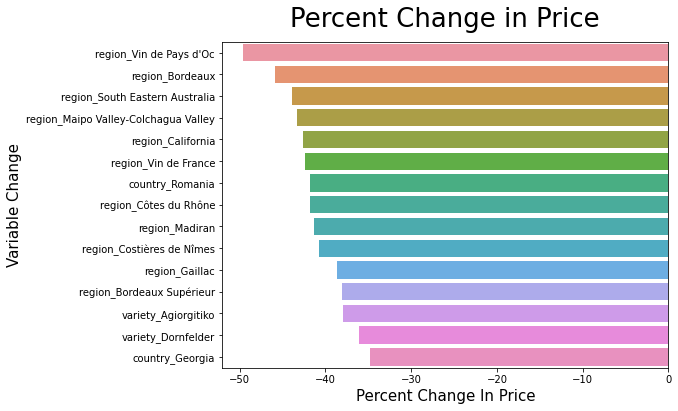

In [101]:
df_ols_neg = df_ols_neg.head(15)

plt.figure(figsize=(8,6))
plt.title('Percent Change in Price',fontsize=26, pad = 15)

# plotting prices x score
ax1 = sns.barplot(x= 'pct_change_in_y',y=df_ols_neg.index,data=df_ols_neg, orient='h')
# ax2 = sns.set(rc={"lines.linewidth": 3})
# ax2 = sns.lineplot(x= [.5,.5], y=[0,1],color='orange');
ax1.set_xlabel('Percent Change In Price', fontsize=15)
ax1.set_ylabel('Variable Change', fontsize=15);

**Interpretation**

- 11 of the 15 negative movers are regions and again we see quite a few european regions.
    - Others of interest are Australia and Cotes du Rhone (our favorite).
- The non-region items here can best be described as obscure when it comes to wine.
    - We rarely see wines from Romania or Georgia (the country).
    - Agiorgitiko and Dornfelder are varietals we have sampled.

[Table of Contents](#Table-of-Contents)
## Conclusions & Next Steps

Our exploratory data and model coefficient analysis have helped us along to path to understanding how the price of wine and how we can make our drinking budgets go further.

**EDA Learnings**
- Using a cost-per-point metric, we were able to find countries, regions and wine varietals that offer a lower cost for the same review score. 
    * For those of us who like wines that fall on the right side of this analysis, we can save money by buying wines that we already like or step in quality not pay too much to do so.
    * The next step here for our team is to try different varietals with the same score. Then each of us can judge how consistently we can trust these reviews.
- Our exploration of the words in the wine reviews gave us a feel for some of the factors that people look for in a premium red wine:
    * Oak barrels
    * Cabernet over Pinot Noir
- EDA on our clustered data seemed to suggest that we have made some good choices in choosing our features as the KPrototypes clustering gave us some more or less distinct groups of wines.
    * With additional data points and a balance of wines, it will be interesting to see how these might change in future studies.

**Modeling Learnings**
- Our predictive model is off to a nice start but it certainly is not ready for prime time. 
    * While it looks pretty good  up to about \\$150, things go a little off of the rails after that.
- Our coefficient analysis can point us in directions to save money on a quality wine or avoid some of the factors that can jack up the price. 
    * From now on, we will be looking a little closer before buying a bottle of the newest reserve wine and try to locate a wine from the same region with comparable reviews.

**Future Research**
- In gathering our data, we did find some great data resources that we didn't have the budget to pay for. 
- With this data, we could both expand and narrow our study. 
    * Expanding to include more wines and more reviews from multiple review sources, perhaps creating an average review score.
    * We can also narrow our scope on pricing side, averaging what we would pay at a set of retailers that we can actually access,
- If forced, we're even willing to include white wine.


## References

- https://www.kaggle.com/zynicide/wine-reviews
- https://www.winemag.com/
- https://www.wine-searcher.com/grape-varieties 
- https://www.thewinecellarinsider.com/wine-topics/wine-educational-questions/abc-of-wine-glossary-of-wine-terms/
- https://en.wikipedia.org/wiki/Pinot_noir#Synonyms (example of wikipedia information used)
- https://data.library.virginia.edu/interpreting-log-transformations-in-a-linear-model/